# E-tivity 1 (Weeks 1-2)

* Barry Clarke

* 24325082

## Anomaly Detection

### Context
We have a mystery dataset. There are 9 explanatory variables and one response variable. The response variable is the last column and indicates if the sample is anomalous (=1, valid =0). The dataset is provided "data.csv".

Of course in this case we could use supervised learning to generate a model and detect anomalies in new data. However the focus is on autoencoders, anomaly detection is just one of the potential uses for autoencoders.

So we are going to pretend that we do not know which data are anomalous but we do know that the anomaly rate is small. Use an autoencoder to detect anomalies in the data. The correctness of the model can of course be checked.

### Guidelines

The e-tivity is split into four tasks. The first three are "group" excersises, in that you post the solutions to Tasks 1-3 to a site. This will allow the members of your group to send you feedback (via the forums) so you can improve your submission. The final task is an individual task and together with the other tasks, should be uploaded to the Group Locker.

Marks will be deducted if task 4 is uploaded in contravention of instructions. Also if the the final submission is not a single notebook with tasks 1-4 and with correct identification or filename.

Grading guidelines: the scores for each task are additive. Below is a link to the E-tivity rubrics.

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks



## Problem

If you train even a modest feed forward network via supervised learning you can get extremely good recall and precision, despite the unbalanced dataset. However in this e-tivity you will determining the anomalies by using an autoencoder. That is you will **not** be using the Anom flag to guide the training.

The mystery dataset is available from Brightspace, download the csv file and use it as the input data.

### Tasks 1-3 (complete by Sunday Week 2)

Create additional cells to implement the tasks below. These task form the group learning section of the E-tivity. As such it is encouraged that you post yuor notebook in the group locker.

Grading guidelines are given in the rubrics for the E-tivity

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks

**Task 1: data preprocessing**

Explain any preprocessing steps you take and also how you have selected the training and test sets. Remember we do not know which samples are anomalous only that there are a small number of them compared to the total sample size.


**Task 2: model generation and training**

Generate a suitable autoencoder model, the only restriction is that there should be only 2 latent variables. Train the model to a satistifactory result. Be aware that it will be much harder to achieve the sort of result you can get from a supervised learning model.

**Hint**: it should not take longer than a 1000 epochs to train. However it may be difficult to train. Use different optimizers, topologies and/or weight initialisations to get convergence. Remember that achieving a perfect error means that the model will also be good at reconstructing anomalies.


**Task 3: anomaly detection**

From the histogram of the reconstruction error decide what the cutoff should be applied to distinguish anomalies from valid samples, given that the anomaly rate is ~7%.

### Post (complete by Sunday Week 1)

Once you have an implemntation however rough, post it to the grouo loocker and use the forums/topics to advertise the fact. The purpose is to get feedback from others in the group, so if you have only a basic outline then you may get ideas about how to proceed and also examples from others in your group.

No posts should refer to Task 4.

This forms part of the overall assessment for the E-tivity.

### Respond (complete by Wednesday Week 2)

If you feel you can provide useful advise then respond to another member of the group through the appropriate forum. Responses should be respectful and offer some sort of advise. Try and avoid clogging the forums with support or thank you messages.

In reviewing others code you will discover different ways to tackle the same problem. It is acceptable to copy parts of others code. However whole scale copying from another notebook is not acceptable.

If you stick to the deadline then it will allow yourself and others to have enough time to implement suggestions. From the Schedule you can see that this is not a hard deadline.

The posts on the forum/topic associated with this e-tivity are graded. Below is a link to the rubrics.

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks

### Final Submission (complete by Sunday Week 2)

Submit Tasks 1-4 in a single notebook this before the deadline on Sunday.


In [1]:
# ==========================================
# Task 1: Data Preprocessing
# ==========================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load the dataset
df = pd.read_csv('data.csv')
print("Dataset loaded successfully.")

# 2. Inspect the data
# Check dimensions and preview data structure
print(df.head())
print("Data shape:", df.shape)

# 3. Separate features and target
# Logic follows 'REF_DimRedComparison'; inputs (X) separated from target (y)
# 'Anom' dropped from X; forbidden for training by instructions
# 'y' retained solely for post-training validation (Tasks 3 & 4)
X = df.drop('Anom', axis=1)
y = df['Anom']

# 4. Split into training and test sets
# Standard 80/20 split used (matching Ref Cell 4)
# Anomalies retained in X_train; distribution unknown per brief
# Autoencoder expected to learn normal patterns and treat rare anomalies as noise
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Scale the data
# StandardScaler applied (Mean=0, Variance=1); consistent with Ref Cell 4/5
# Required for fair MSE calculation across features
# Scaler fit only on training data to prevent leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training data shape:", X_train_scaled.shape)
print("Test data shape:", X_test_scaled.shape)

Dataset loaded successfully.
   V1  V2  V3  V4  V5  V6  V7  V8  V9  Anom
0  50  21  77   0  28   0  27  48  22     1
1  53   0  82   0  52  -5  29  30   2     0
2  37   0  76   0  28  18  40  48   8     0
3  37   0  79   0  34 -26  43  46   2     0
4  85   0  88  -4   6   1   3  83  80     1
Data shape: (49097, 10)
Training data shape: (39277, 9)
Test data shape: (9820, 9)


In [2]:
# ==========================================
# Task 2: Model Generation and Training
# ==========================================

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# 1. Define the architecture
# The instructions require exactly 2 latent variables.
input_dim = X_train_scaled.shape[1]  # 9 features
encoding_dim = 2                     # Set to 2 to meet the "2 latent variables" requirement

# Input Layer
# Using the Keras Functional API style, similar to 'REF_CNN_AE.ipynb'.
input_layer = Input(shape=(input_dim,))

# Encoder Layers
# Using Dense layers to compress the data, similar to the logic in 'REF_DimRedComparison.ipynb'.
# Stepping down from 9 inputs -> 6 nodes -> 2 latent variables.
encoder = Dense(6, activation='relu')(input_layer)
encoder = Dense(encoding_dim, activation='linear', name="bottleneck")(encoder)

# Decoder Layers
# "Mirroring" the encoder to expand the data back to the original size (9).
# This symmetric structure is standard for AEs (as seen in the reference notes).
decoder = Dense(6, activation='relu')(encoder)
decoder = Dense(input_dim, activation='linear')(decoder) # Output layer

# 2. Create the Model
# Combining input and output into a Model, just like in 'REF_CNN_AE.ipynb' (Cell 1).
autoencoder = Model(inputs=input_layer, outputs=decoder)

# 3. Compile the Model
# Using 'adam' and 'mean_squared_error' (MSE).
# This matches the compiler settings used in 'REF_DimRedComparison.ipynb' for reconstruction.
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 4. View Summary
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155 (620.00 B)

 Trainable params: 155 (620.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6789 - val_loss: 0.4038
Epoch 2/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4827 - val_loss: 0.3572
Epoch 3/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3988 - val_loss: 0.3327
Epoch 4/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3500 - val_loss: 0.3204
Epoch 5/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4168 - val_loss: 0.3025
Epoch 6/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3419 - val_loss: 0.2956
Epoch 7/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3546 - val_loss: 0.2929
Epoch 8/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3382 - val_loss: 0.2817
Epoch 9/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2970 - val_loss: 0.2874
Epoch 10/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3235 - val_loss: 0.2933
Epoch 11/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2477 - val_loss: 0.2949
Epoch 12/50
1228/1228 ━━━━━━━━

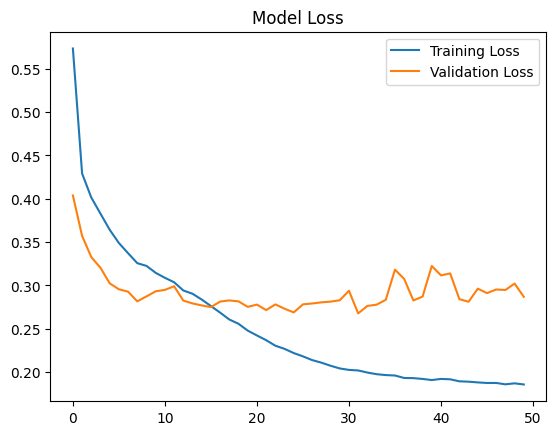

Total execution time: 1 min 32.50 sec
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
Calculated Threshold (93rd percentile): 0.0999


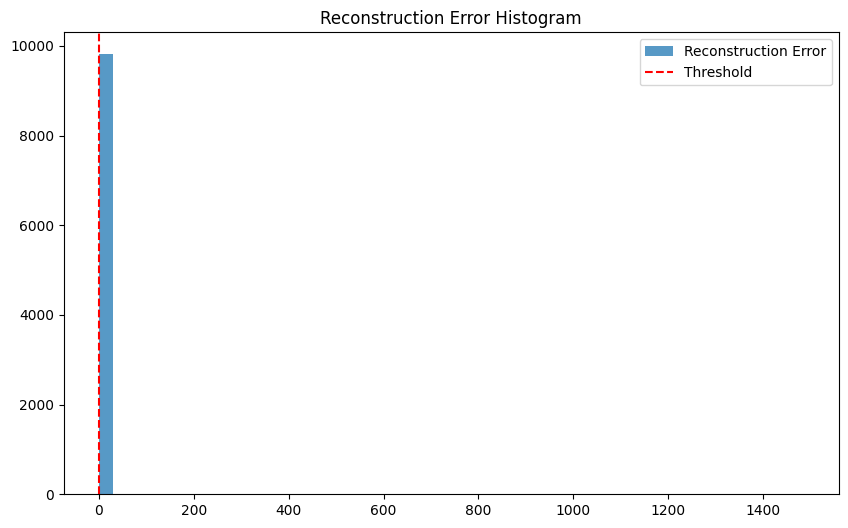

In [3]:
# ==========================================
# Task 3: Anomaly Detection
# ==========================================

import time
import matplotlib.pyplot as plt
import numpy as np

# Start the timer to track training duration (as requested by the hint in Task 2)
start_time = time.time()

# 1. Train the model
# The model is trained to reconstruct its own input (X -> X).
# This matches the self-supervised approach seen in 'REF_CNN_AE.ipynb'.
# Input and Target are both 'X_train_scaled'.
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=50,       # Well within the 1000 epoch limit mentioned in the brief
    batch_size=32,
    shuffle=True,    # Shuffling data is standard practice (seen in Ref Cell 10)
    validation_data=(X_test_scaled, X_test_scaled),
    verbose=1
)

# 2. Plot Training Loss
# Visualising the loss helps confirm convergence, similar to plots in 'REF_DimRedComparison.ipynb'.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Stop the timer
end_time = time.time()
total_seconds = end_time - start_time

# Convert to minutes and seconds
minutes, seconds = divmod(total_seconds, 60)
print(f"Total execution time: {int(minutes)} min {seconds:.2f} sec")

# 3. Anomaly Detection Logic
# To find the cutoff, the reconstruction error (MSE) for the test set is calculated.
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

# The instructions state the anomaly rate is ~7%.
# Therefore, the threshold is set at the 93rd percentile of the error distribution.
# This logic assumes the highest 7% of errors correspond to the anomalies.
threshold = np.percentile(mse, 93)

print(f"Calculated Threshold (93rd percentile): {threshold:.4f}")

# 4. Visualisation
# Plotting the histogram to visually verify the separation, as suggested by the task description.
plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, alpha=0.75, label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Histogram')
plt.legend()
plt.show()

## Reflection

There are no specific marks allocated for a reflection. However due consideration will be given if pertinent comments or valuable insights are made.